In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Домашнее задание №1: визуализация, k-NN регрессия, кросс-валидация.

В этом задании мы рассмотрим задачу прогнозирования количества взятых в аренду велосипедов.

Файл [bike_sharing.csv](https://yadi.sk/d/n8iy_trO3EsUBa) содержит данные о 731 дне работы сервиса по аренде велосипедов. Про каждый день известны:

* instant: record index
* dteday : date
* season : season (1:springer, 2:summer, 3:fall, 4:winter)
* yr : year (0: 2011, 1:2012)
* mnth : month ( 1 to 12)
* holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius from 0 to 100.
- atemp: Normalized feeling temperature in Celsius from 0 to 100.
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

**1. (0.25 балла)** Откройте файл bike_sharing.csv, запишите в датафрейм df и выведите первые пять строк датафрейма.

In [25]:
data = pd.read_csv('bike_sharing.csv')
data.head(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,34.4167,36.3625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,36.3478,35.3739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,19.6364,18.9405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,20.0000,21.2122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,22.6957,22.9270,0.436957,0.186900,82,1518,1600


**2. (1 балл)** Постройте график среднего числа арендованных байков (cnt) по каждому месяцу. Не забудьте подписать оси координат. Убедитесь, что в летние месяцы велосипеды в прокат берут чаще.

([<matplotlib.axis.XTick at 0x7ff8b84742e8>,
 <a list of 12 Text xticklabel objects>)

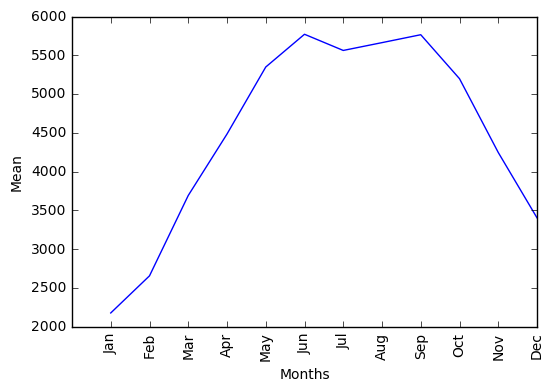

In [37]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
x = data['mnth'].unique()
plt.plot(x, data.groupby('mnth')['cnt'].mean())
plt.xlabel('Months')
plt.ylabel('Mean')
plt.xticks(x, months, rotation='vertical')

** 3. (0.5 балла)** Постройте диаграмму рассеяния (scatter plot) с осями cnt и atemp, где точки — это объекты. Какой логичный вывод можно сделать по этому графику?

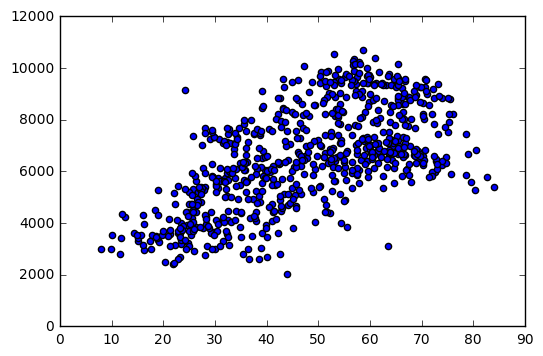

In [52]:
plt.scatter(data['atemp'], data['cnt']+2000)
# when the feeling temperature is higher people rent more bikes

**4. (0.5 балла)** Преобразуйте небинарные категориальные признаки с помощью one-hot кодирования. Сделать это можно с помощью функции pd.get_dummies, указав нужные столбцы в параметре columns. Сколько признаков получилось после кодирования? И какой категориальный признак породил больше всего бинарных?

In [ ]:
#read more

**5. (0.25 балла)** Удалите столбцы instant, dteday, casual и registered. Предположите, почему мы удаляем эти признаки.

In [43]:
data = data.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)
# instant - !unique! index, which does not affect on prediction
# dteday - we do not need date, because we have name of week day, type of week day (working/weekend/holiday),
# year and so on. Date is not important for predicrions anymore.
# we do not need count of casual and registered users because ?

**6. (0.5 балла)** Далее нашей целевой переменной будет количество арендованных велосипедов (cnt). Поэтому запишите cnt в переменную df_ans и удалите из df. Затем в помощью функции train_test_split из sklearn.model_selection разделите выборку на обучающую и контрольную в отношении 7 к 3, создав переменные X_train, X_test, y_train, y_test.

Замечание 1: установите random_seed, чтобы генератор псевдослучайных чисел работал всегда одинаково.

Замечание 2: если в sklearn.model_selection нет функции train_test_split, обновите scikit-learn.

**7. (1 балл)** Обучите алгоритм пяти ближайших соседей с евклидовой метрикой и оцените MAE на контрольной выборке.

**8. (0.5 балла)** Постройте диаграмму рассеяния (scatter plot), по одной оси отметив настоящее число аренд велосипедов, а по другой — предсказанное алгоритмом. Дополнительно на этом графике постройте прямую $y = x$. Чему соотстветствует отклонение от этой прямой?

**9. (1 балл)** Отмасштабируйте признаки, чтобы они принимали значения на $[0, 1]$.

Это можно сделать собственноручно с помощью операций pandas.

Иначе — можно использовать MinMaxScaler из sklearn.preprocessing — класс с методами fit и transform. 
Для этого:

* либо соедините X_train и X_test обратно в единый датафрейм, отмасштабируйте и разъедините обратно,
* либо отмасштабируйте df (без ответов) и разделите на обучающую и контрольную выборку, используя тот же random_seed.

На выходе метода transform получится numpy-массив, который нужно будет превратить обратно в датафрейм.

**10. (0.5 балла)** Вновь обучите алгоритм пяти ближайших соседей с евклидовой метрикой и оцените MAE на контрольной выборке. Почему качество поменялось?

**11. (1.25 балла)** Используя класс KFold из sklearn.model_selection установите с помощью кросс-валидации на пяти фолдах, какой параметр weights лучше с точки зрения mean absolute error. 

**12. (2.5 балла)** С помощью GridSearchCV из sklearn.model_selection на пяти фолдах выберите лучшее значение $k$ от 1 до 50. Постройте график MAE на кросс-валидации в зависимости от $k$. 

Замечание: Передать нужную метрику качества для GridSearchCV можно через параметр scoring, но не всё так просто. Из метрики качества нужно сделать «scorer» c помощью функции sklearn.metrics.make_scorer, не забыв указать нужное значение greater_is_better.

**13. (0.25 балла)** Посчитайте качество итоговой модели на контрольной выборке. 